In [22]:
# entire code is being run on an Ubuntu kernel. 
# not many QoL libraries are needed.
# your mileage may vary.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# training specific imports
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# AI imports
import torch
import torchvision

# statistics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve

# test if GPU acceleration is working
torch.cuda.is_available()

True

In [23]:
# load dataset annotations file
annot = pd.read_csv('./disaster-dataset/annotations.csv', delimiter=';')
annot.head()

,id,filename,A1.Q1,A1.Q2,A1.Q3.1,A1.Q3.2,A1.Q3.3,A1.Q3.4,A1.Q3.5,A1.Q3.6,...,A5.Q4.8,A5.Q4.9,A5.Q4.10,A5.Q5.1,A5.Q5.2,A5.Q5.3,A5.Q5.4,A5.Q5.5,A5.Q5.6,A5.Q5.7
0,052464df-5fdb-428a-9a4a-6036ea023b42,052464df-5fdb-428a-9a4a-6036ea023b42.jpg,4,7,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,2ce9b1bc-ee70-4128-85d1-0fd3ac272619,2ce9b1bc-ee70-4128-85d1-0fd3ac272619.jpg,6,5,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2280b9f3-6989-4222-a0d9-ec4bd35d731b,2280b9f3-6989-4222-a0d9-ec4bd35d731b.jpg,7,9,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,257a8e84-7738-49e2-9945-7f082bf7ad34,257a8e84-7738-49e2-9945-7f082bf7ad34.jpg,1,5,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,3f6b222a-049c-4803-9cbb-5ea734110ed0,3f6b222a-049c-4803-9cbb-5ea734110ed0.jpg,1,9,0,1,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [24]:
annot.isna().sum().sum() == 0

True

### FIND A WAY TO CONDENSE 132 COLUMNS DOWN

15/9/23 Update: Solved with the help of a professor. Every annotator is now a valid output, and the data is to be trained using Cross Validation. See [ISSUE #8](https://github.com/projectayre/ayre/issues/8) for more details

In [34]:
questions = np.array(list([i[3:] for i in annot.columns[2:28]]))

In [35]:
questions

array(['Q1', 'Q2', 'Q3.1', 'Q3.2', 'Q3.3', 'Q3.4', 'Q3.5', 'Q3.6', 'Q3.7',
       'Q4.1', 'Q4.2', 'Q4.3', 'Q4.4', 'Q4.5', 'Q4.6', 'Q4.7', 'Q4.8',
       'Q4.9', 'Q4.10', 'Q5.1', 'Q5.2', 'Q5.3', 'Q5.4', 'Q5.5', 'Q5.6',
       'Q5.7'], dtype='<U5')

I will rename these using the proper names given to them in [info.txt](./disaster-dataset/info.txt)

In [36]:
values = ['sentiment polarity', 'stimulation and excitement', # Continuous output (1-9, needs normalization)
          'Joy', 'Sadness', 'Fear', 'Disgust', 'Anger', 'Surprise', 'Neutral', # Category 1 (Major emotion)
          'Anger', 'Anxiety', 'Craving', 'Emphatic pain', 'Fear', 'Horror', 
          'Joy', 'Relief', 'Sadness', 'Surprise', # Category 2 (Specific emotion)
          'Human facial expression gesture', 'Inherent image property', 'Image background', 
          'Objects in image', 'Text in image', 'Emoji sticker', 'Halo effect'] # Category 3 (Reason for emotion)
rename_dict = dict(zip(questions, values))
len(rename_dict) == len(questions) # Inconsistency has been resolved.

True

In [41]:
rename_dict

{'Q1': 'sentiment polarity',
 'Q2': 'stimulation and excitement',
 'Q3.1': 'Joy',
 'Q3.2': 'Sadness',
 'Q3.3': 'Fear',
 'Q3.4': 'Disgust',
 'Q3.5': 'Anger',
 'Q3.6': 'Surprise',
 'Q3.7': 'Neutral',
 'Q4.1': 'Anger',
 'Q4.2': 'Anxiety',
 'Q4.3': 'Craving',
 'Q4.4': 'Emphatic pain',
 'Q4.5': 'Fear',
 'Q4.6': 'Horror',
 'Q4.7': 'Joy',
 'Q4.8': 'Relief',
 'Q4.9': 'Sadness',
 'Q4.10': 'Surprise',
 'Q5.1': 'Human facial expression gesture',
 'Q5.2': 'Inherent image property',
 'Q5.3': 'Image background',
 'Q5.4': 'Objects in image',
 'Q5.5': 'Text in image',
 'Q5.6': 'Emoji sticker',
 'Q5.7': 'Halo effect'}

There is the mistake in the dataset, Q4 is supposed only has 9 categories, and Q5 7. However, Q4 has 10 and Q5 has 6. I'm not sure what to do here.

15/9/23: FIXED. Found a research paper done on the same dataset, and it gave me this: https://www.mdpi.com/1424-8220/22/10/3628 

In [64]:
# Write code to seperate blocks out of the dataframe for each annotator so they can be stitched together
images = annot.iloc[:, 0:2]
labels = annot.drop(['id', 'filename'], axis=1)
labellist = []
for i in range(5):
    labellist.append(labels.iloc[:, 26*i:26*(i+1)].to_numpy())
labellist = np.vstack(np.array(labellist))
labellist.shape # this is now the stitched block lmao

(18395, 26)

In [66]:
# convert labellist to dataframe
labels = pd.DataFrame(labellist, columns=values)
labels.head()

,sentiment polarity,stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,Anger,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
0,4,7,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,6,5,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,7,9,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,5,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,1,9,0,1,1,0,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0


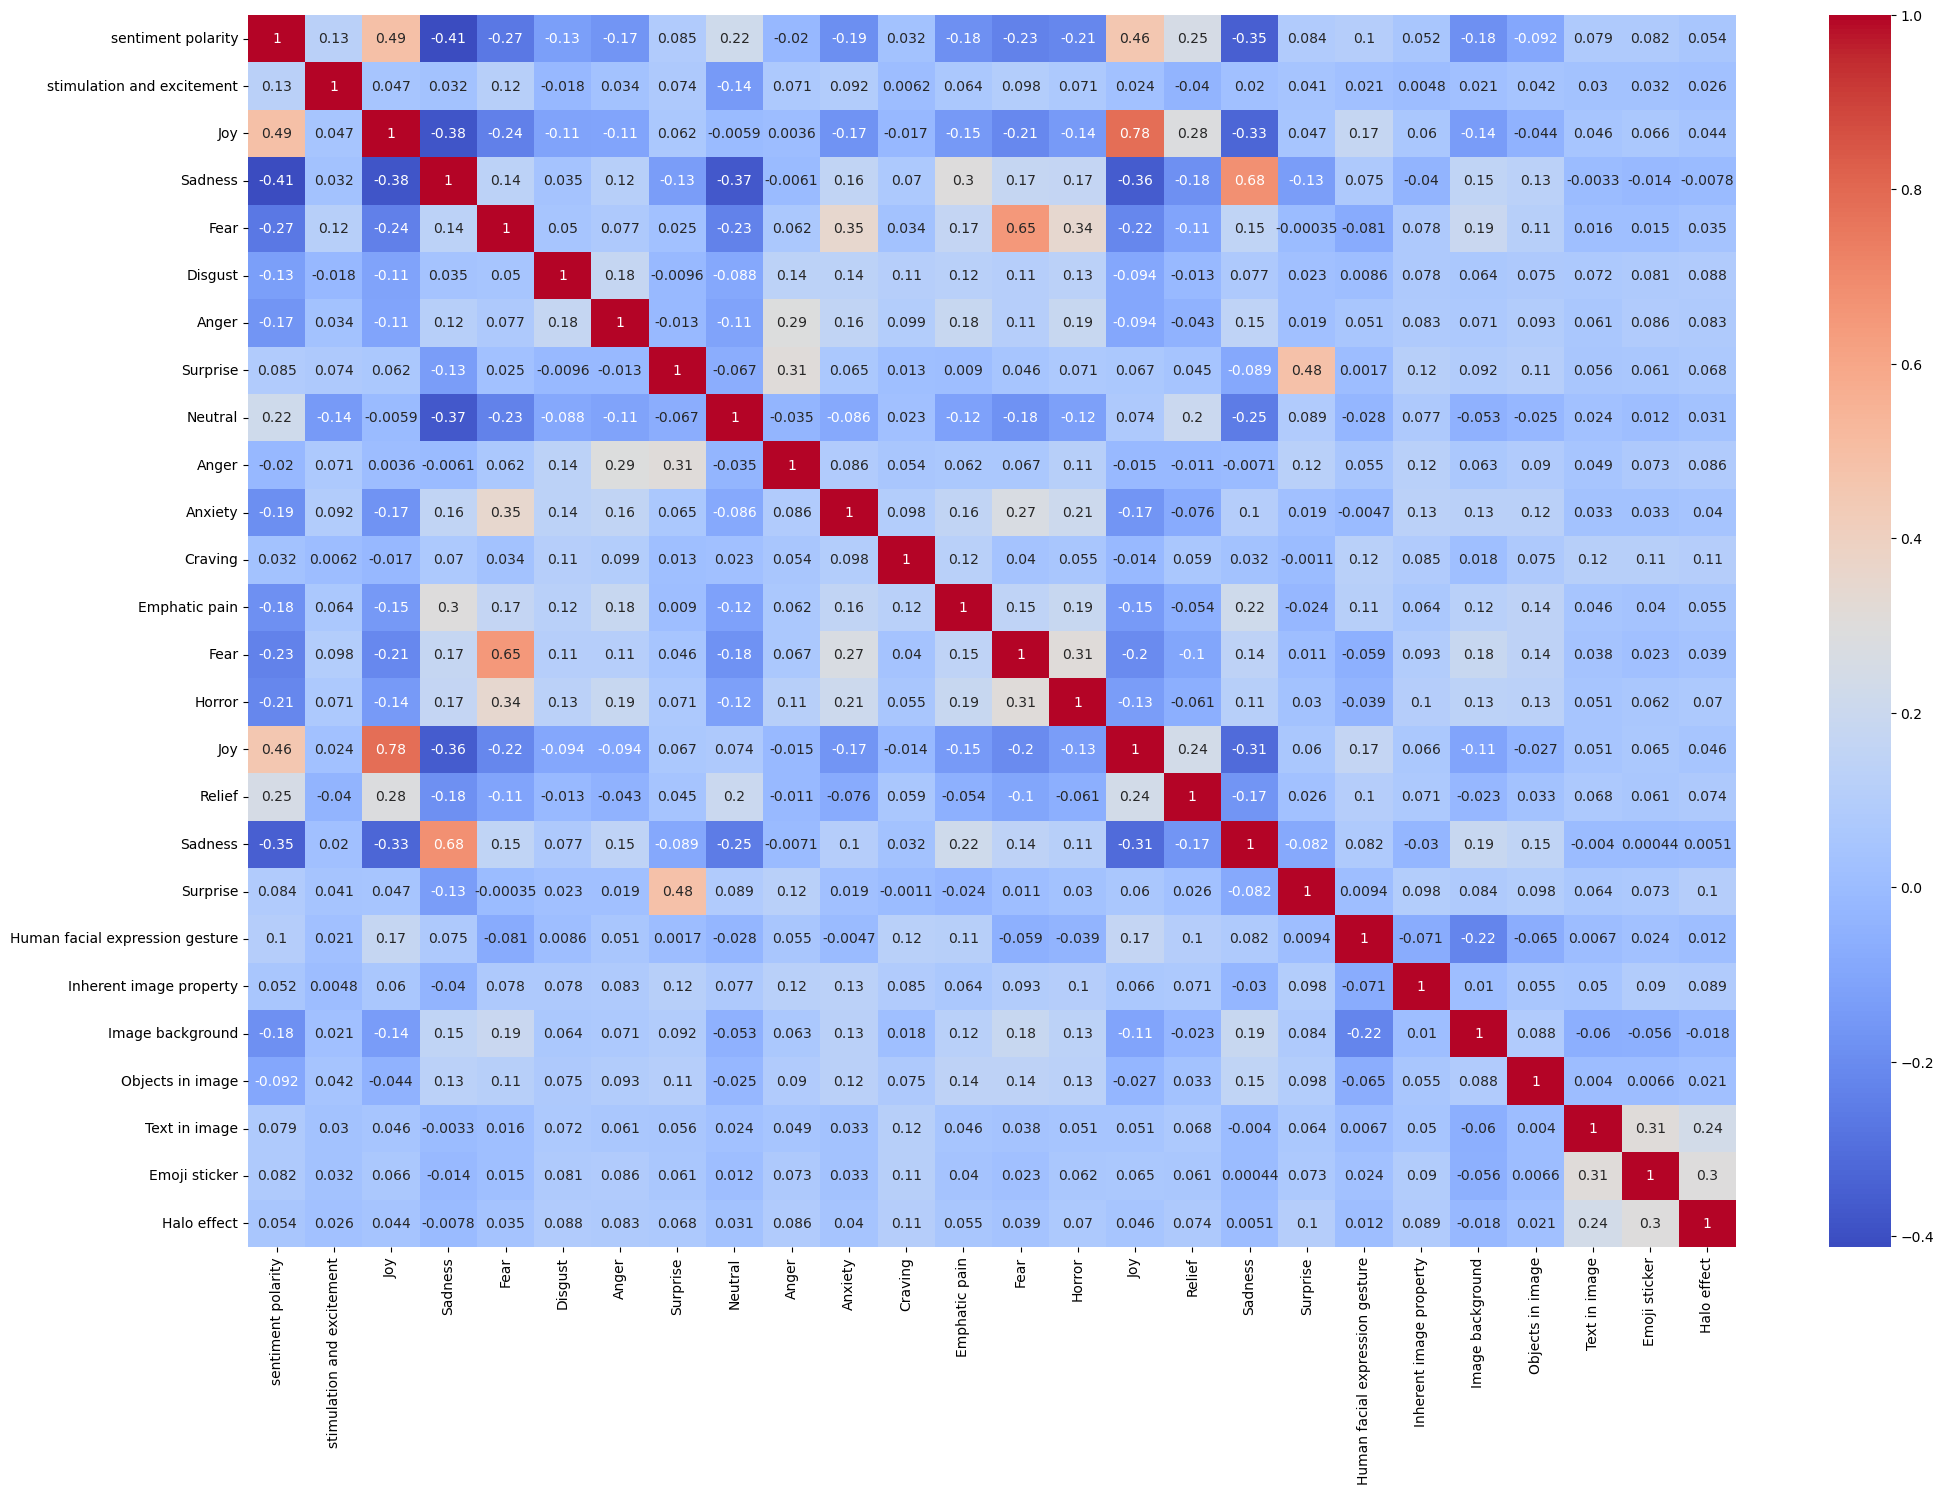

In [67]:
# final correlation between all labels
plt.figure(figsize=(24, 16))
sns.heatmap(labels.corr(), cmap='coolwarm', annot=True)
plt.show()

In [68]:
labels.describe()

,sentiment polarity,stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,Anger,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
count,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,...,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000,18395.000000
mean,4.083175,6.070943,0.130796,0.587388,0.336341,0.100082,0.101767,0.182821,0.159391,0.175646,...,0.100625,0.519598,0.152107,0.411525,0.224572,0.661865,0.397989,0.021691,0.012612,0.015711
std,2.802773,2.285514,0.337187,0.492318,0.472470,0.300117,0.302350,0.386531,0.366050,0.380529,...,0.300840,0.499629,0.359134,0.492123,0.417311,0.473088,0.489496,0.145675,0.111596,0.124358
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,8.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,9.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Load images
root = './disaster-dataset/images/'
